# Import packages

In [12]:
import math

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

# Configure seed to be used

In [13]:
pl.set_random_seed(42)
np.random.seed(42)

# Utility functions

In [14]:
standardize_columns = lambda x: x.lower().strip().replace(" ", "_")

In [15]:
def clipper(amount: float, min: float, max: float) -> float:
    if amount < min:
        return min
    elif amount > max:
        return max
    else:
        return amount

# Load dataset

In [16]:
df = pl.read_csv("../data/data_science_competition_2024.csv")

## Standardize columns

In [17]:
df = df.rename(standardize_columns)

# EDA & Feature Engineering

In [18]:
df.sample(3)

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults_duplicated_0,remaining_term,salary,marital_status,age_duplicated_0,loan_status
i64,str,str,str,str,str,str,bool,str,str,f64,i64,f64,f64,i64,i64,str,f64,str,i64,str
70198,"""d594f6e9-40c2-411f-9bc7-b57a05…","""male""","""2021 04 27""","""USD""","""Zimbabwe""","""male""",true,"""Teacher""","""Harare""",42000.0,0,39851.191587,0.17,40,0,"""51""",2926.285237,"""single""",40,"""Did not default"""
71745,"""9cda9a77-801d-4b8f-9e82-fc15fe…","""male""","""2020 06 11""","""USD""","""Zimbabwe""","""male""",true,"""Accountant""","""Nyanga""",29000.0,1,36617.974963,0.2,30,1,"""44""",2523.355452,"""divorced""",30,"""Did not default"""
79446,"""44c6b8a0-84e2-4691-9f36-a00fa6…","""female""","""2021 08 29""","""USD""","""Zimbabwe""","""female""",true,"""Accountant""","""Chimanimani""",20000.0,2,34105.380385,0.21,36,2,"""31""",1862.811343,"""divorced""",36,"""Did not default"""


## Check for null values

In [19]:
df.null_count()

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults_duplicated_0,remaining_term,salary,marital_status,age_duplicated_0,loan_status
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,100,0,0,4136,595,0,0,0,0,0,0,0,0,0,0,0


## Loan status

In [20]:
df = df.with_columns(
    pl.col("loan_status")
    .map_elements(
        lambda x: 1 if x == "Defaulted" else 0, return_dtype=pl.datatypes.Int32
    )
    .alias("defaulted")
)

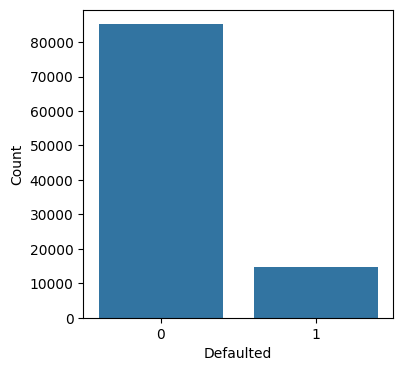

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.barplot(
    df.group_by("defaulted").len().to_pandas(), x="defaulted", y="len", ax=ax
)
ax.set(xlabel="Defaulted", ylabel="Count")
plt.show()

In [22]:
df.sample(3)

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults_duplicated_0,remaining_term,salary,marital_status,age_duplicated_0,loan_status,defaulted
i64,str,str,str,str,str,str,bool,str,str,f64,i64,f64,f64,i64,i64,str,f64,str,i64,str,i32
26143,"""5291741f-436b-408a-b592-ee2056…","""male""","""2020 07 03""","""USD""","""Zimbabwe""","""male""",true,"""Teacher""","""Gweru""",54000.0,0,44735.960229,0.19,43,0,"""98""",5884.033526,"""single""",43,"""Did not default""",0
10774,"""627f7bd7-9b42-473f-8dd9-22db65…","""other""","""2022 05 13""","""USD""","""Zimbabwe""","""other""",true,"""Engineer""","""Gweru""",40000.0,0,28857.87507,0.21,49,0,"""69""",3483.131093,"""married""",49,"""Did not default""",0
88362,"""0ac3d279-9789-49e1-8257-7a34c2…","""other""","""2023 08 16""","""USD""","""Zimbabwe""","""other""",true,"""Engineer""","""Bulawayo""",33000.0,0,47707.43463,0.2,47,0,"""48""",2488.592742,"""married""",47,"""Did not default""",0


## Gender and sex

- Either sex or gender can be dropped since they contain the same number of people in each of the genders available

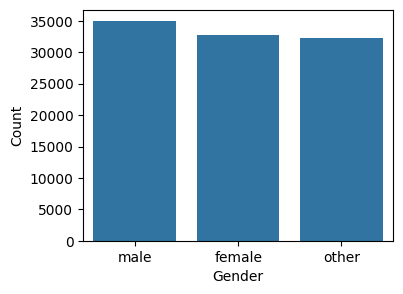

In [23]:
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.barplot(df.group_by("gender").len().to_pandas(), x="gender", y="len")
ax.set(xlabel="Gender", ylabel="Count")
plt.show()

In [24]:
df.group_by("gender").agg(
    pl.col('defaulted').filter(pl.col('defaulted') == 1).count().alias('defaulted'),
    pl.col('defaulted').filter(pl.col('defaulted') == 0).count().alias('not_defaulted')
)

gender,defaulted,not_defaulted
str,u32,u32
"""other""",5210,27077
"""female""",4059,28626
"""male""",5597,29431


<Axes: xlabel='gender', ylabel='count'>

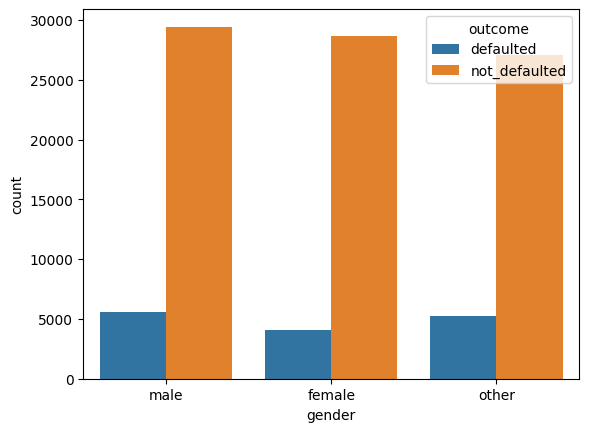

In [25]:
sns.barplot(
    df.group_by("gender")
    .agg(
        pl.col("defaulted").filter(pl.col("defaulted") == 1).count().alias("defaulted"),
        pl.col("defaulted")
        .filter(pl.col("defaulted") == 0)
        .count()
        .alias("not_defaulted"),
    )
    .melt(
        id_vars="gender",
        value_vars=["defaulted", "not_defaulted"],
        variable_name="outcome",
        value_name="count",
    ),
    x="gender",
    hue="outcome",
    y="count",
)

In [26]:
df = df.with_columns(df.select("gender").to_dummies())

In [27]:
df.group_by("gender").len().sort("gender").to_pandas()

,gender,len
0,female,32685
1,male,35028
2,other,32287


In [28]:
df.group_by("sex").len().sort("sex").to_pandas()

,sex,len
0,female,32685
1,male,35028
2,other,32287


## Disbursement date

- Month and day features can be created using the disbursement date

In [29]:
df = df.with_columns(pl.col("disbursemet_date").str.to_date(format="%Y %m %d"))

In [30]:
df = df.with_columns(
    [
        pl.col("disbursemet_date").dt.month().alias("disbursemet_month"),
        pl.col("disbursemet_date").dt.day().alias("disbursemet_day"),
    ]
)

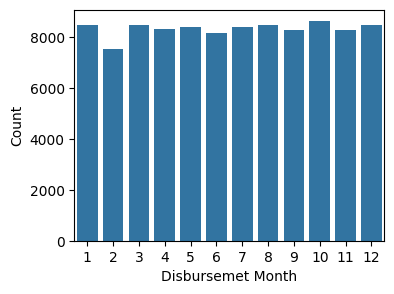

In [31]:
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.barplot(
    df.group_by("disbursemet_month").len().to_pandas(), x="disbursemet_month", y="len"
)
ax.set(xlabel="Disbursemet Month", ylabel="Count")
plt.show()

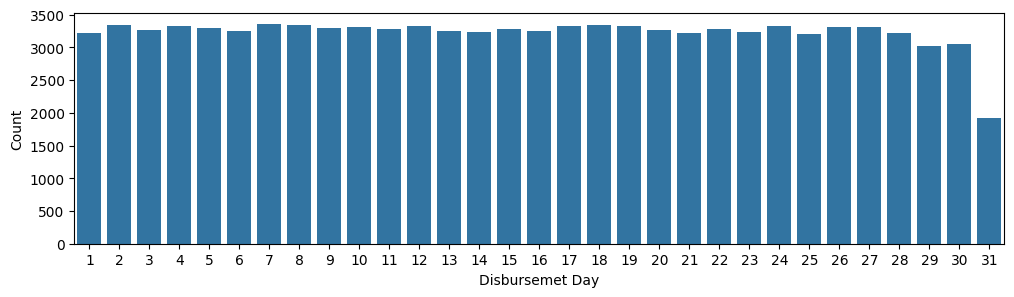

In [32]:
fig, ax = plt.subplots(figsize=(12, 3))
ax = sns.barplot(
    df.group_by("disbursemet_day").len().to_pandas(), x="disbursemet_day", y="len"
)
ax.set(xlabel="Disbursemet Day", ylabel="Count")
plt.show()

## Currency

- The currency column can be dropped since all rows are in USD

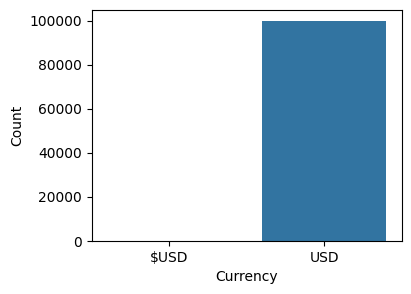

In [33]:
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.barplot(df.group_by("currency").len().to_pandas(), x="currency", y="len")
ax.set(xlabel="Currency", ylabel="Count")
plt.show()

In [34]:
df.group_by("currency").len().to_pandas()

,currency,len
0,$USD,20
1,USD,99980


## Country and location

- Some rows have country set to `None` but the country can be inferred using the city name
- Only 1 row has an unknown country and city, so that row can be dropped
- [Coordinates for all cities except Gokwe](https://www.tageo.com/index-e-zi-cities-ZW.htm)
- [Coordinates for Gokwe](https://latitude.to/map/zw/zimbabwe/cities)

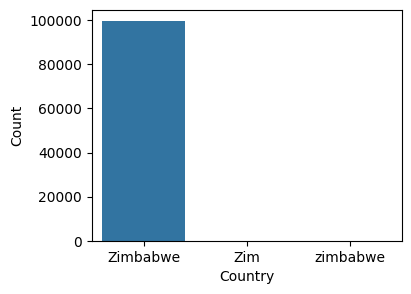

In [35]:
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.barplot(df.group_by("country").len().to_pandas(), x="country", y="len")
ax.set(xlabel="Country", ylabel="Count")
plt.show()

In [36]:
df.group_by("country").len().to_pandas()

,country,len
0,None,100
1,zimbabwe,100
2,Zim,13
3,Zimbabwe,99787


In [37]:
def add_country_if_city_exists(*args):
    args = args[0]
    country = args[0]
    city = args[1]

    if country is None and city is not None:
        return "Zimbabwe"
    return country

In [38]:
df = df.with_columns(
    df.select(["country", "location"])
    .map_rows(add_country_if_city_exists)
    .to_series()
    .alias("country")
)

In [39]:
df.group_by("country").len().sort("len").to_pandas()

,country,len
0,None,1
1,Zim,13
2,zimbabwe,100
3,Zimbabwe,99886


In [40]:
df.filter(pl.col("country").is_null() & pl.col("location").is_null())

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults_duplicated_0,remaining_term,salary,marital_status,age_duplicated_0,loan_status,defaulted,gender_female,gender_male,gender_other,disbursemet_month,disbursemet_day
i64,str,str,date,str,str,str,bool,str,str,f64,i64,f64,f64,i64,i64,str,f64,str,i64,str,i32,u8,u8,u8,i8,i8
85223,"""d7bcf845-8fef-4d6c-9f25-b0cb21…","""other""",2022-01-13,"""USD""",null,"""other""",true,"""Engineer""",null,32000.0,2,36775.579301,0.17,51,2,"""65""",2694.375568,"""single""",51,"""Defaulted""",1,0,0,1,1,13


In [41]:
df.select("location").unique().sort("location").to_series().to_list()[:8]

[None,
 '   Beitbridge ',
 '   Beitbridge   ',
 '   Bulawayo ',
 '   Bulawayo   ',
 '   Chimanimani ',
 '   Chimanimani   ',
 '   Chipinge ']

In [42]:
df = df.with_columns(
    pl.col("location").map_elements(
        lambda x: x.lower().strip().replace(" ", "_"), return_dtype=pl.datatypes.String
    )
)

In [43]:
df = df.with_columns(pl.col("location").fill_null("other"))

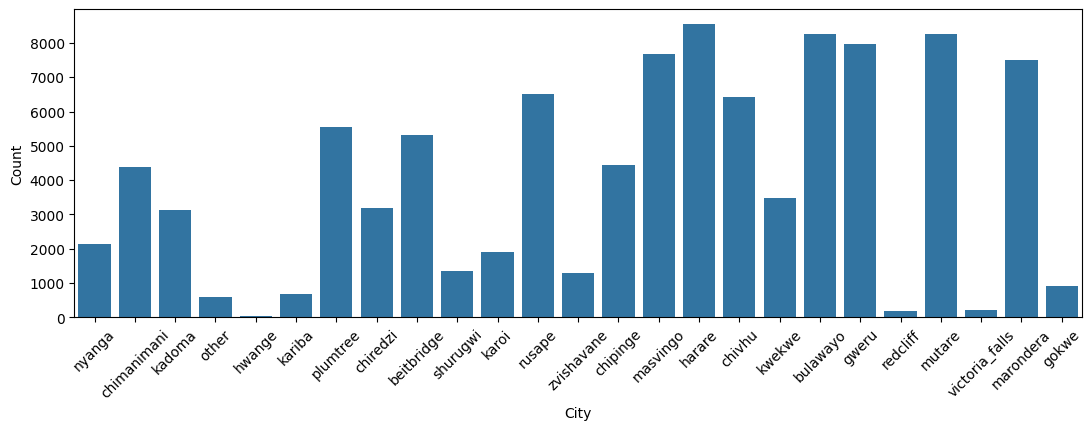

In [44]:
fig, ax = plt.subplots(figsize=(13, 4))
ax = sns.barplot(
    df.group_by("location").len().to_pandas(), x="location", y="len", ax=ax
)
ax.set(xlabel="City", ylabel="Count")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [45]:
location_mapping = {
    "kariba": [-16.530, 28.800],
    "beitbridge": [-22.210, 29.990],
    "harare": [-17.820, 31.050],
    "kadoma": [-18.330, 29.910],
    "chimanimani": [-19.810, 32.860],
    "gweru": [-19.450, 29.820],
    "hwange": [-18.370, 26.500],
    "shurugwi": [-19.660, 30.000],
    "karoi": [-16.820, 29.680],
    "chiredzi": [-21.050, 31.660],
    "kwekwe": [-18.930, 29.800],
    "rusape": [-18.530, 32.120],
    "marondera": [-18.190, 31.550],
    "zvishavane": [-20.330, 30.050],
    "mutare": [-18.970, 32.650],
    "plumtree": [-20.490, 27.810],
    "victoria_falls": [-17.930, 25.840],
    "nyanga": [-18.210, 32.740],
    "redcliff": [-19.030, 29.770],
    "chipinge": [-20.200, 32.620],
    "bulawayo": [-20.170, 28.580],
    "masvingo": [-20.060, 30.820],
    "chivhu": [-19.020, 30.890],
    "gokwe": [-18.20476, 28.9349],
    "other": [-50, 50],
}


def get_coordinates_by_location(location: str, coordinate_type: str) -> float:
    if coordinate_type == "lat":
        return location_mapping[location][0]
    elif coordinate_type == "long":
        return location_mapping[location][1]
    else:
        return location_mapping[location]

In [46]:
df = df.with_columns(
    [
        pl.col("location")
        .map_elements(
            lambda x: get_coordinates_by_location(x, "lat"),
            return_dtype=pl.datatypes.Float32,
        )
        .alias("city_lat"),
        pl.col("location")
        .map_elements(
            lambda x: get_coordinates_by_location(x, "long"),
            return_dtype=pl.datatypes.Float32,
        )
        .alias("city_long"),
    ]
)

In [47]:
df = df.with_columns(df.select("location").to_dummies())
df.sample(3)

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults_duplicated_0,remaining_term,salary,marital_status,age_duplicated_0,loan_status,defaulted,gender_female,gender_male,gender_other,disbursemet_month,disbursemet_day,city_lat,city_long,location_beitbridge,location_bulawayo,location_chimanimani,location_chipinge,location_chiredzi,location_chivhu,location_gokwe,location_gweru,location_harare,location_hwange,location_kadoma,location_kariba,location_karoi,location_kwekwe,location_marondera,location_masvingo,location_mutare,location_nyanga,location_other,location_plumtree,location_redcliff,location_rusape,location_shurugwi,location_victoria_falls,location_zvishavane
i64,str,str,date,str,str,str,bool,str,str,f64,i64,f64,f64,i64,i64,str,f64,str,i64,str,i32,u8,u8,u8,i8,i8,f32,f32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
12933,"""ab09e7c8-6a47-43b1-ab14-d9fef2…","""female""",2022-09-19,"""USD""","""Zimbabwe""","""female""",true,"""Accountant""","""chivhu""",34000.0,0,34763.0337,0.22,39,0,"""58""",3248.173354,"""divorced""",39,"""Did not default""",0,1,0,0,9,19,-19.02,30.889999,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
87189,"""a853caa3-38fa-4efe-9ca6-010696…","""male""",2020-04-25,"""USD""","""Zimbabwe""","""male""",true,"""Data Scientist""","""chimanimani""",109500.0,0,52141.218939,0.23,32,0,"""49""",4030.83087,"""divorced""",32,"""Did not default""",0,0,1,0,4,25,-19.809999,32.860001,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77508,"""846a960a-ce82-46db-b22b-7ee4bf…","""male""",2020-06-24,"""USD""","""Zimbabwe""","""male""",true,"""Nurse""","""chipinge""",53000.0,0,41232.507672,0.22,58,0,"""59""",2753.436738,"""single""",58,"""Did not default""",0,0,1,0,6,24,-20.200001,32.619999,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Employed

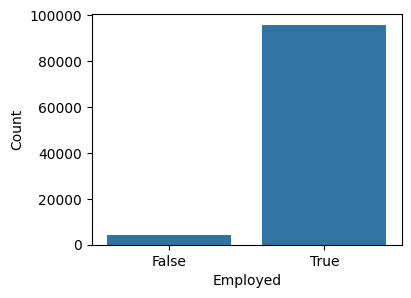

In [48]:
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.barplot(df.group_by("is_employed").len().to_pandas(), x="is_employed", y="len")
ax.set(xlabel="Employed", ylabel="Count")
plt.show()

<Axes: xlabel='is_employed', ylabel='count'>

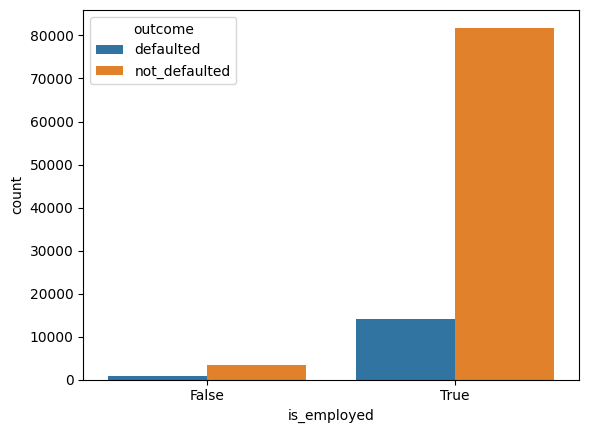

In [49]:
sns.barplot(
    df.group_by("is_employed")
    .agg(
        pl.col("defaulted").filter(pl.col("defaulted") == 1).count().alias("defaulted"),
        pl.col("defaulted")
        .filter(pl.col("defaulted") == 0)
        .count()
        .alias("not_defaulted"),
    )
    .melt(
        id_vars="is_employed",
        value_vars=["defaulted", "not_defaulted"],
        variable_name="outcome",
        value_name="count",
    ),
    x="is_employed",
    hue="outcome",
    y="count",
)

## Job

- `data_scintist` is a mispelling of `data_scientist`
- `softwaredeveloper` and `software_developer` refer to the same job, so either one can be renamed to match the other

In [50]:
def rename_job(job: str) -> str:
    if job == "data_scintist":
        return "data_scientist"
    elif job == "softwaredeveloper":
        return "software_developer"
    else:
        return job

In [51]:
df = df.with_columns(
    pl.col("job")
    .map_elements(
        lambda x: x.lower().strip().replace(" ", "_"), return_dtype=pl.datatypes.String
    )
    .map_elements(rename_job, return_dtype=pl.datatypes.String)
)
df = df.with_columns(pl.col("job").fill_null("other"))

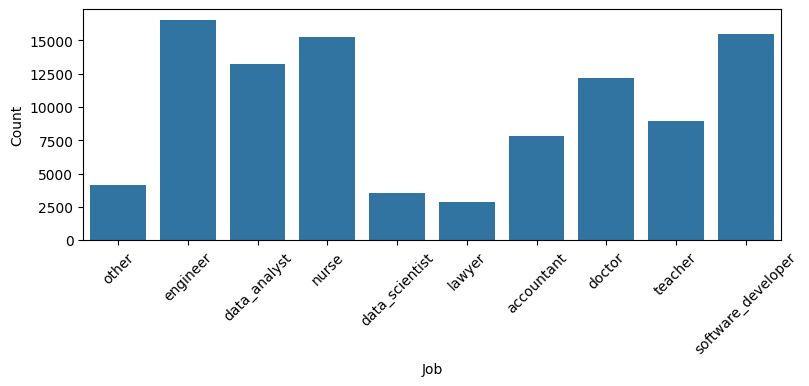

In [52]:
fig, ax = plt.subplots(figsize=(9, 3))
ax = sns.barplot(df.group_by("job").len().to_pandas(), x="job", y="len", ax=ax)
ax.set(xlabel="Job", ylabel="Count")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [53]:
df = df.with_columns(df.select("job").to_dummies())
df.sample(3)

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults_duplicated_0,remaining_term,salary,marital_status,age_duplicated_0,loan_status,defaulted,gender_female,gender_male,gender_other,disbursemet_month,disbursemet_day,city_lat,city_long,location_beitbridge,location_bulawayo,location_chimanimani,location_chipinge,location_chiredzi,location_chivhu,location_gokwe,location_gweru,location_harare,location_hwange,location_kadoma,location_kariba,location_karoi,location_kwekwe,location_marondera,location_masvingo,location_mutare,location_nyanga,location_other,location_plumtree,location_redcliff,location_rusape,location_shurugwi,location_victoria_falls,location_zvishavane,job_accountant,job_data_analyst,job_data_scientist,job_doctor,job_engineer,job_lawyer,job_nurse,job_other,job_software_developer,job_teacher
i64,str,str,date,str,str,str,bool,str,str,f64,i64,f64,f64,i64,i64,str,f64,str,i64,str,i32,u8,u8,u8,i8,i8,f32,f32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
22466,"""f6fc292a-c267-4cde-b055-a83706…","""other""",2022-02-09,"""USD""","""Zimbabwe""","""other""",true,"""software_developer""","""masvingo""",29000.0,1,32127.272265,0.21,42,1,"""68""",3357.767851,"""married""",42,"""Did not default""",0,0,0,1,2,9,-20.059999,30.82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
69242,"""96243ae7-4a44-4361-8f2f-077f84…","""male""",2021-10-02,"""USD""","""Zimbabwe""","""male""",true,"""data_scientist""","""gweru""",60000.0,0,41947.502877,0.19,43,0,"""63""",4106.653477,"""single""",43,"""Did not default""",0,0,1,0,10,2,-19.450001,29.82,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5469,"""75efb880-e035-4859-8390-dedf9d…","""male""",2023-11-29,"""USD""","""Zimbabwe""","""male""",true,"""software_developer""","""plumtree""",18000.0,2,37231.970667,0.22,43,2,"""63""",2686.021711,"""divorced""",43,"""Did not default""",0,0,1,0,11,29,-20.49,27.809999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Loan amount

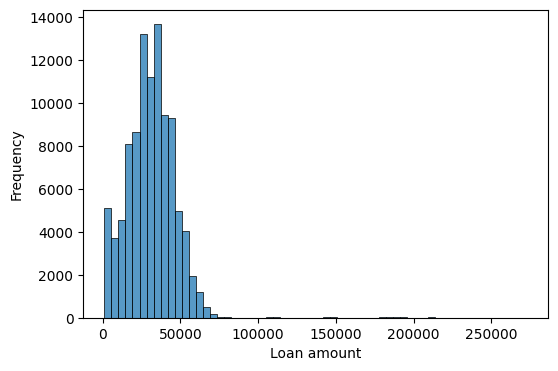

In [54]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(df.to_pandas(), x="loan_amount", bins=60)
ax.set(xlabel="Loan amount", ylabel="Frequency")
plt.show()

In [55]:
df = df.with_columns(
    df.select(
        pl.col("loan_amount").map_elements(
            lambda x: clipper(x, 0, 70000), return_dtype=pl.datatypes.Float32
        )
    )
)

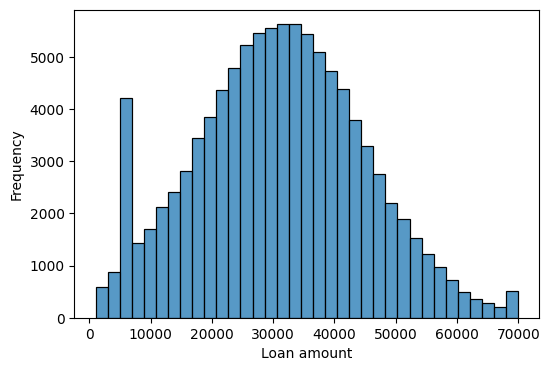

In [56]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(df.to_pandas(), x="loan_amount", bins=35)
ax.set(xlabel="Loan amount", ylabel="Frequency")
plt.show()

## Number of defaults

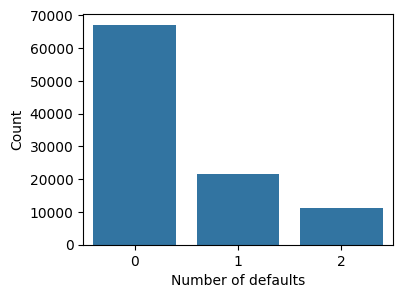

In [57]:
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.barplot(
    df.group_by("number_of_defaults").len().to_pandas(),
    x="number_of_defaults",
    y="len",
    ax=ax,
)
ax.set(xlabel="Number of defaults", ylabel="Count")
plt.show()

<Axes: xlabel='number_of_defaults', ylabel='count'>

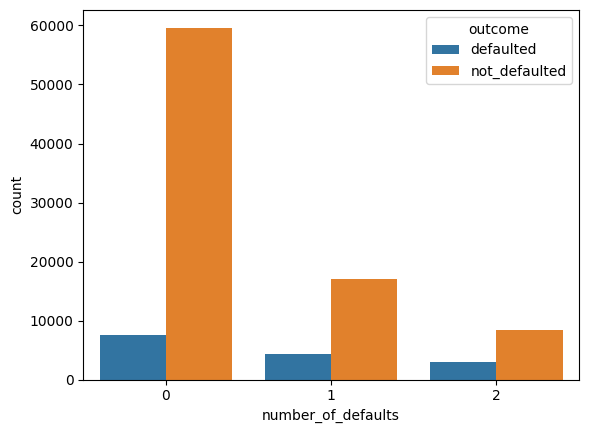

In [58]:
sns.barplot(
    df.group_by("number_of_defaults")
    .agg(
        pl.col("defaulted").filter(pl.col("defaulted") == 1).count().alias("defaulted"),
        pl.col("defaulted")
        .filter(pl.col("defaulted") == 0)
        .count()
        .alias("not_defaulted"),
    )
    .melt(
        id_vars="number_of_defaults",
        value_vars=["defaulted", "not_defaulted"],
        variable_name="outcome",
        value_name="count",
    ),
    x="number_of_defaults",
    hue="outcome",
    y="count",
)

In [59]:
df.group_by("number_of_defaults").len().to_pandas()

,number_of_defaults,len
0,0,67158
1,2,11355
2,1,21487


In [60]:
df.group_by("number_of_defaults_duplicated_0").len().to_pandas()

,number_of_defaults_duplicated_0,len
0,2,11355
1,1,21487
2,0,67158


- `number_of_defaults_duplicated_0` must be a duplicate of `number_of_defaults`. So the column can be dropped

## Outstanding balance

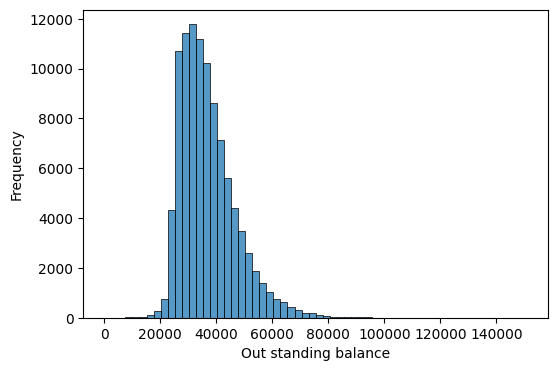

In [61]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(df.to_pandas(), x="outstanding_balance", bins=60)
ax.set(xlabel="Out standing balance", ylabel="Frequency")
plt.show()

In [62]:
df = df.with_columns(
    df.select(
        pl.col("outstanding_balance").map_elements(
            lambda x: clipper(x, 15000, 80000), return_dtype=pl.datatypes.Float32
        )
    )
)

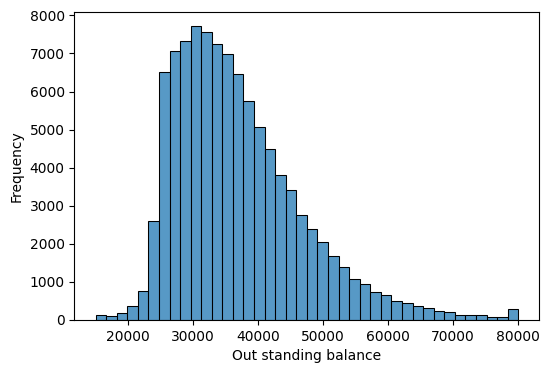

In [63]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(df.to_pandas(), x="outstanding_balance", bins=40)
ax.set(xlabel="Out standing balance", ylabel="Frequency")
plt.show()

## Age

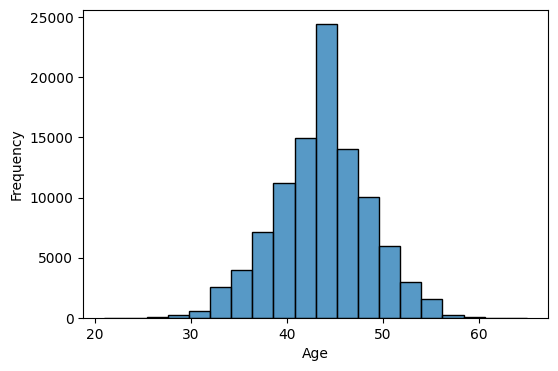

In [64]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(df.to_pandas(), x="age", bins=20)
ax.set(xlabel="Age", ylabel="Frequency")
plt.show()

- `age_duplicated_0` must be a duplicate of `age`. So the column can be dropped

## Remaining term

In [65]:
df = df.with_columns(
    [
        pl.col("remaining_term").map_elements(
            lambda x: int(str(x).strip().replace("_", "")),
            return_dtype=pl.datatypes.Int32,
        )
    ]
)

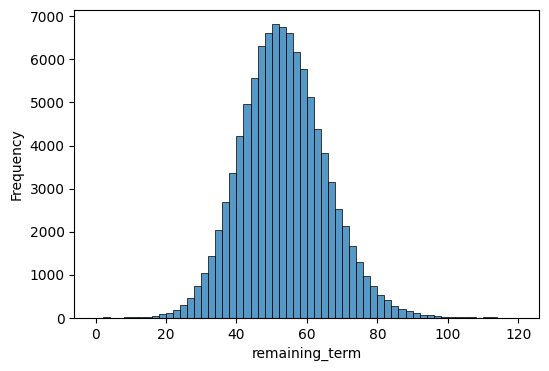

In [66]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(df.to_pandas(), x="remaining_term", bins=60)
ax.set(xlabel="remaining_term", ylabel="Frequency")
plt.show()

## Salary

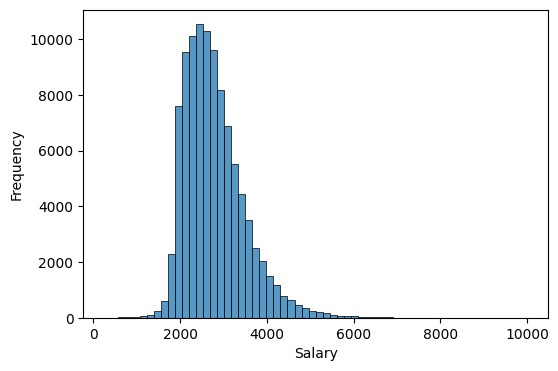

In [67]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(df.to_pandas(), x="salary", bins=60)
ax.set(xlabel="Salary", ylabel="Frequency")
plt.show()

- Can be grouped by low, lower-mid, middle-mid, higher-mid and high income earners or group by tax bracket

## Marital status

In [68]:
df = df.with_columns(
    pl.col("marital_status").map_elements(
        lambda x: x if len(x) > 3 else "other", return_dtype=pl.datatypes.String
    )
)

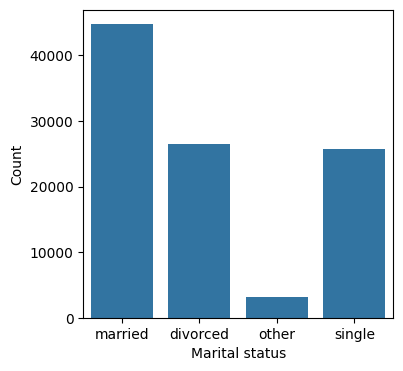

In [69]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.barplot(
    df.group_by("marital_status").len().to_pandas(), x="marital_status", y="len", ax=ax
)
ax.set(xlabel="Marital status", ylabel="Count")
plt.show()

<Axes: xlabel='marital_status', ylabel='count'>

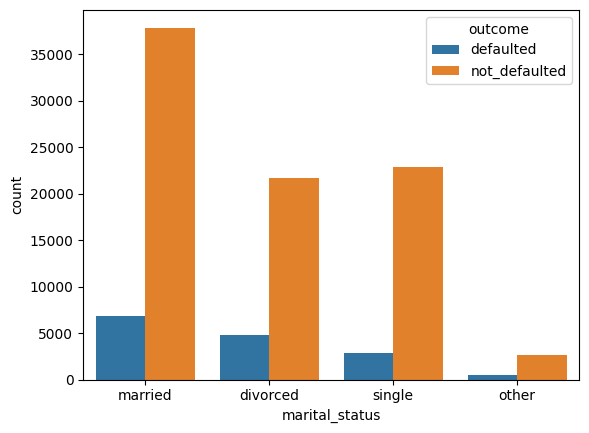

In [70]:
sns.barplot(
    df.group_by("marital_status")
    .agg(
        pl.col("defaulted").filter(pl.col("defaulted") == 1).count().alias("defaulted"),
        pl.col("defaulted")
        .filter(pl.col("defaulted") == 0)
        .count()
        .alias("not_defaulted"),
    )
    .melt(
        id_vars="marital_status",
        value_vars=["defaulted", "not_defaulted"],
        variable_name="outcome",
        value_name="count",
    ),
    x="marital_status",
    hue="outcome",
    y="count",
)

In [71]:
df = df.with_columns(df.select("marital_status").to_dummies())
df.sample(3)

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults_duplicated_0,remaining_term,salary,marital_status,age_duplicated_0,loan_status,defaulted,gender_female,gender_male,gender_other,disbursemet_month,disbursemet_day,city_lat,city_long,location_beitbridge,location_bulawayo,location_chimanimani,location_chipinge,location_chiredzi,location_chivhu,location_gokwe,location_gweru,location_harare,location_hwange,location_kadoma,location_kariba,location_karoi,location_kwekwe,location_marondera,location_masvingo,location_mutare,location_nyanga,location_other,location_plumtree,location_redcliff,location_rusape,location_shurugwi,location_victoria_falls,location_zvishavane,job_accountant,job_data_analyst,job_data_scientist,job_doctor,job_engineer,job_lawyer,job_nurse,job_other,job_software_developer,job_teacher,marital_status_divorced,marital_status_married,marital_status_other,marital_status_single
i64,str,str,date,str,str,str,bool,str,str,f32,i64,f32,f64,i64,i64,i32,f64,str,i64,str,i32,u8,u8,u8,i8,i8,f32,f32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
98146,"""7953bfd5-cb84-4d64-8148-257f8a…","""other""",2021-05-07,"""USD""","""Zimbabwe""","""other""",true,"""engineer""","""marondera""",35000.0,1,47726.726562,0.24,43,1,32,1927.134281,"""divorced""",43,"""Did not default""",0,0,0,1,5,7,-18.190001,31.549999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
65567,"""8791653f-f08a-4b62-a275-88ef39…","""other""",2021-10-31,"""USD""","""Zimbabwe""","""other""",true,"""data_analyst""","""bulawayo""",26000.0,0,35042.261719,0.22,43,0,63,3057.47891,"""other""",43,"""Did not default""",0,0,0,1,10,31,-20.17,28.58,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
44171,"""ce665f16-76ed-4826-a1ca-23177e…","""female""",2020-02-13,"""USD""","""Zimbabwe""","""female""",true,"""doctor""","""gweru""",26000.0,0,38094.207031,0.2,37,0,48,2550.099305,"""divorced""",37,"""Did not default""",0,1,0,0,2,13,-19.450001,29.82,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


## Check for null values

In [72]:
df.null_count()

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults_duplicated_0,remaining_term,salary,marital_status,age_duplicated_0,loan_status,defaulted,gender_female,gender_male,gender_other,disbursemet_month,disbursemet_day,city_lat,city_long,location_beitbridge,location_bulawayo,location_chimanimani,location_chipinge,location_chiredzi,location_chivhu,location_gokwe,location_gweru,location_harare,location_hwange,location_kadoma,location_kariba,location_karoi,location_kwekwe,location_marondera,location_masvingo,location_mutare,location_nyanga,location_other,location_plumtree,location_redcliff,location_rusape,location_shurugwi,location_victoria_falls,location_zvishavane,job_accountant,job_data_analyst,job_data_scientist,job_doctor,job_engineer,job_lawyer,job_nurse,job_other,job_software_developer,job_teacher,marital_status_divorced,marital_status_married,marital_status_other,marital_status_single
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Drop columns and null values

- Gender can be dropped so as to reduce bias

In [73]:
df = df.drop_nulls()

In [74]:
print(f"Number of rows {df.shape[0]}")

Number of rows 99999


In [75]:
df.sample(3)

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults_duplicated_0,remaining_term,salary,marital_status,age_duplicated_0,loan_status,defaulted,gender_female,gender_male,gender_other,disbursemet_month,disbursemet_day,city_lat,city_long,location_beitbridge,location_bulawayo,location_chimanimani,location_chipinge,location_chiredzi,location_chivhu,location_gokwe,location_gweru,location_harare,location_hwange,location_kadoma,location_kariba,location_karoi,location_kwekwe,location_marondera,location_masvingo,location_mutare,location_nyanga,location_other,location_plumtree,location_redcliff,location_rusape,location_shurugwi,location_victoria_falls,location_zvishavane,job_accountant,job_data_analyst,job_data_scientist,job_doctor,job_engineer,job_lawyer,job_nurse,job_other,job_software_developer,job_teacher,marital_status_divorced,marital_status_married,marital_status_other,marital_status_single
i64,str,str,date,str,str,str,bool,str,str,f32,i64,f32,f64,i64,i64,i32,f64,str,i64,str,i32,u8,u8,u8,i8,i8,f32,f32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
18671,"""6825242e-2526-4383-a017-72c478…","""other""",2023-08-24,"""USD""","""Zimbabwe""","""other""",true,"""data_analyst""","""chivhu""",33000.0,0,36037.703125,0.22,44,0,37,2148.597459,"""married""",44,"""Did not default""",0,0,0,1,8,24,-19.02,30.889999,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
67855,"""6f16d6e7-f5c9-4fa4-ac81-5880ef…","""other""",2020-07-04,"""USD""","""Zimbabwe""","""other""",true,"""lawyer""","""chipinge""",28000.0,2,32568.894531,0.23,39,2,62,3533.089876,"""divorced""",39,"""Did not default""",0,0,0,1,7,4,-20.200001,32.619999,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
57306,"""afa98861-49dd-4ae6-a13e-dee8c6…","""female""",2020-01-12,"""USD""","""Zimbabwe""","""female""",true,"""engineer""","""chivhu""",8000.0,0,27563.6875,0.24,48,0,40,1956.109155,"""married""",48,"""Did not default""",0,1,0,0,1,12,-19.02,30.889999,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [76]:
df_clean = df.drop(
    [
        "loan_id",
        "",
        # "gender",
        "disbursemet_date",
        "currency",
        "country",
        "sex",
        "job",
        "location",
        "number_of_defaults_duplicated_0",
        "marital_status",
        "age_duplicated_0",
        "loan_status",
        "city_lat",
        "city_long",
    ]
)

In [77]:
df_clean.sample(3)

gender,is_employed,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining_term,salary,defaulted,gender_female,gender_male,gender_other,disbursemet_month,disbursemet_day,location_beitbridge,location_bulawayo,location_chimanimani,location_chipinge,location_chiredzi,location_chivhu,location_gokwe,location_gweru,location_harare,location_hwange,location_kadoma,location_kariba,location_karoi,location_kwekwe,location_marondera,location_masvingo,location_mutare,location_nyanga,location_other,location_plumtree,location_redcliff,location_rusape,location_shurugwi,location_victoria_falls,location_zvishavane,job_accountant,job_data_analyst,job_data_scientist,job_doctor,job_engineer,job_lawyer,job_nurse,job_other,job_software_developer,job_teacher,marital_status_divorced,marital_status_married,marital_status_other,marital_status_single
str,bool,f32,i64,f32,f64,i64,i32,f64,i32,u8,u8,u8,i8,i8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
"""male""",true,18000.0,0,27567.375,0.22,44,56,2470.604348,0,0,1,0,8,27,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
"""female""",true,3000.0,2,24738.708984,0.21,55,44,1883.524928,0,1,0,0,1,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
"""other""",true,37000.0,0,35831.65625,0.21,46,53,2824.921456,0,0,0,1,2,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


## Calculate mutual information

In [78]:
df_analysis = df.drop(
    [
        "",
        "loan_id",
        "disbursemet_date",
        "currency",
        "country",
        "sex",
        "number_of_defaults_duplicated_0",
        "age_duplicated_0",
        "loan_status",
        "city_lat",
        "city_long",
        "location_beitbridge",
        "location_bulawayo",
        "location_chimanimani",
        "location_chipinge",
        "location_chiredzi",
        "location_chivhu",
        "location_gokwe",
        "location_gweru",
        "location_harare",
        "location_hwange",
        "location_kadoma",
        "location_kariba",
        "location_karoi",
        "location_kwekwe",
        "location_marondera",
        "location_masvingo",
        "location_mutare",
        "location_nyanga",
        "location_other",
        "location_plumtree",
        "location_redcliff",
        "location_rusape",
        "location_shurugwi",
        "location_victoria_falls",
        "location_zvishavane",
        "job_accountant",
        "job_data_analyst",
        "job_data_scientist",
        "job_doctor",
        "job_engineer",
        "job_lawyer",
        "job_nurse",
        "job_other",
        "job_software_developer",
        "job_teacher",
        "marital_status_divorced",
        "marital_status_married",
        "marital_status_other",
        "marital_status_single",
        "gender_female",
        "gender_male",
        "gender_other",
    ]
)

In [79]:
df_analysis.sample(3)

gender,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining_term,salary,marital_status,defaulted,disbursemet_month,disbursemet_day
str,bool,str,str,f32,i64,f32,f64,i64,i32,f64,str,i32,i8,i8
"""female""",true,"""doctor""","""chimanimani""",23000.0,0,32524.072266,0.2,40,49,2483.55645,"""married""",0,12,6
"""other""",true,"""nurse""","""beitbridge""",38000.0,0,43413.582031,0.25,41,46,2849.859881,"""divorced""",0,2,28
"""female""",true,"""data_analyst""","""chivhu""",42000.0,0,31127.693359,0.2,43,52,3022.768428,"""single""",0,2,2


In [80]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder

In [81]:
enc = OrdinalEncoder()

In [82]:
df_analysis = df_analysis.with_columns(
    pl.Series("gender", enc.fit_transform(df_analysis.select("gender")).flatten()),
    pl.Series("job", enc.fit_transform(df_analysis.select("gender")).flatten()),
    pl.Series("location", enc.fit_transform(df_analysis.select("gender")).flatten()),
    pl.Series("marital_status", enc.fit_transform(df_analysis.select("gender")).flatten()),
)

In [83]:
mi = mutual_info_classif(
    df_analysis.drop("defaulted"),
    df_analysis.select("defaulted").to_series(),
    random_state=42,
    n_jobs=-1,
)

In [84]:
mi = sorted(zip(mi, df_analysis.drop("defaulted").columns))

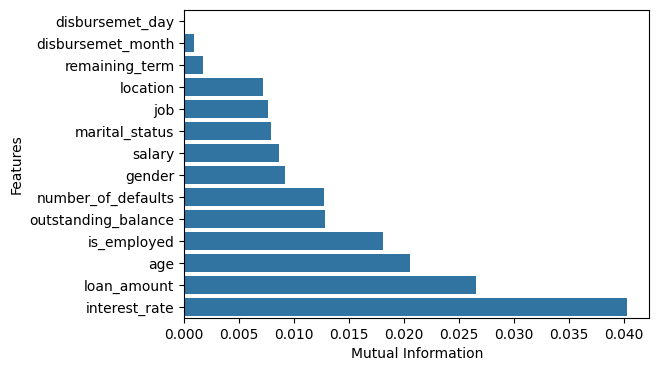

In [85]:
# plot mutual info

fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(
    x=[x[0] for x in mi],
    y=[x[1] for x in mi],
    ax=ax,
)
ax.set(xlabel="Mutual Information", ylabel="Features")
plt.show()

# Model training

## Train, test, val split

In [86]:
df_analysis.drop([
        "disbursemet_month",
        "disbursemet_day",
        "remaining_term",
    ]).write_csv("../data/sample.csv")

In [87]:
X = df_clean.drop(
    [
        "defaulted",
        "disbursemet_month",
        "disbursemet_day",
        "remaining_term",
        "gender",
        "job",
        "location",
        "marital_status",
    ]
)

In [76]:
y = df_clean.select(pl.col("defaulted"))

In [77]:
n_train = 0.7
n_test_val = 0.3

In [78]:
split = StratifiedShuffleSplit(
    n_splits=1,
    train_size=n_train,
    test_size=n_test_val,
    random_state=42,
)

In [79]:
train_idx, test_idx = next(split.split(X, y))

In [80]:
n_test = 0.7
n_val = 0.3

In [81]:
split = StratifiedShuffleSplit(
    n_splits=1,
    train_size=n_val,
    test_size=n_test,
    random_state=42,
)

In [82]:
val_idx, test_idx = next(split.split(X[test_idx], y[test_idx]))

In [83]:
X_train, X_test, X_val = X[train_idx], X[test_idx], X[val_idx]
y_train, y_test, y_val = y[train_idx], y[test_idx], y[val_idx]

In [84]:
X_train.shape, X_test.shape, X_val.shape

((69999, 49), (21000, 49), (9000, 49))

In [85]:
y_train.shape, y_test.shape, y_val.shape

((69999, 1), (21000, 1), (9000, 1))

In [86]:
pos_ratio = lambda X, y: y.to_numpy().sum() / X.shape[0]

In [87]:
pos_ratio(X_train, y_train), pos_ratio(X_test, y_test), pos_ratio(X_val, y_val)

(0.1486449806425806, 0.1509047619047619, 0.144)

## Data normalization and standardization

In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [89]:
std_cols = [
    "number_of_defaults",
    "age",
    "salary",
]
min_max_cols = [col for col in X_train.columns if col not in std_cols]

In [90]:
transformer = ColumnTransformer(
    [
        ("minmax", MinMaxScaler(), min_max_cols),
        ("zscore", StandardScaler(), std_cols),
    ],
)

In [91]:
transformer = transformer.fit(X_train)

In [92]:
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_val = transformer.transform(X_val)

In [93]:
y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()
y_val = y_val.to_numpy().flatten()

In [94]:
class_weight = {0: 0.16, 1: 0.84}

## Logistic regressor

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [96]:
logreg = LogisticRegression()

In [97]:
logreg.fit(X_train, y_train)

LogisticRegression()

### Predict

In [98]:
y_pred = logreg.predict(X_test)

In [99]:
def plot_confusion_matirx(y_test, y_pred, model_name):
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f"Confusion matrix ({model_name})")
    plt.gca().xaxis.set_ticks_position("top")
    plt.gca().xaxis.set_label_position("top")
    plt.show()

In [100]:
def display_classification_report(y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print("\n")
    print(f"Classification report:\n{classification_report(y_test, y_pred)}")

In [101]:
display_classification_report(y_test, y_pred)

Accuracy: 0.8925714285714286


Classification report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     17831
           1       0.79      0.39      0.52      3169

    accuracy                           0.89     21000
   macro avg       0.85      0.69      0.73     21000
weighted avg       0.88      0.89      0.88     21000



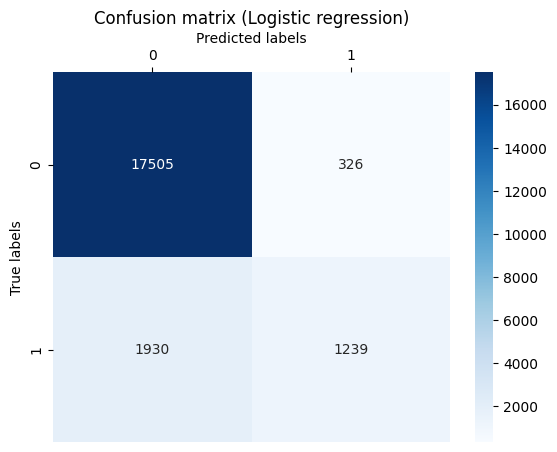

In [102]:
plot_confusion_matirx(y_test, y_pred, "Logistic regression")

### Predict with threshold

In [323]:
threshold = 0.25
y_pred_proba = logreg.predict_proba(X_test)
y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

In [324]:
display_classification_report(y_test, y_pred)

Accuracy: 0.8663809523809524


Classification report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     17831
           1       0.55      0.61      0.58      3169

    accuracy                           0.87     21000
   macro avg       0.74      0.76      0.75     21000
weighted avg       0.87      0.87      0.87     21000



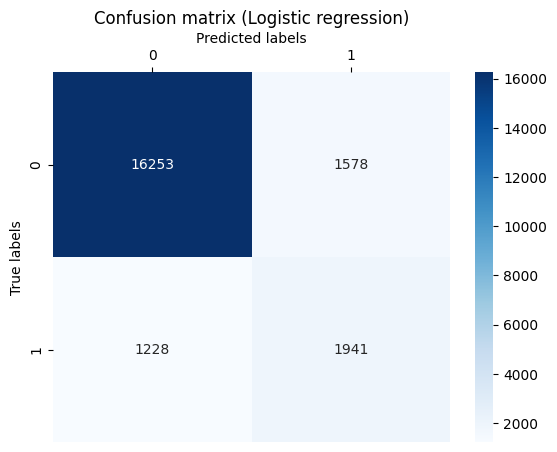

In [325]:
plot_confusion_matirx(y_test, y_pred, "Logistic regression")

## Decision tree

In [326]:
from sklearn.tree import DecisionTreeClassifier

In [327]:
dt = DecisionTreeClassifier(random_state=42, class_weight=class_weight)

In [328]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.16, 1: 0.84}, random_state=42)

In [329]:
y_pred = dt.predict(X_test)

In [330]:
display_classification_report(y_test, y_pred)

Accuracy: 0.9625714285714285


Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     17831
           1       0.88      0.87      0.88      3169

    accuracy                           0.96     21000
   macro avg       0.93      0.93      0.93     21000
weighted avg       0.96      0.96      0.96     21000



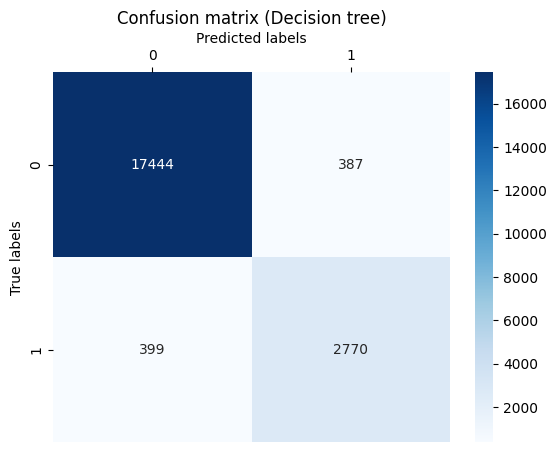

In [331]:
plot_confusion_matirx(y_test, y_pred, "Decision tree")

## Random forest

In [332]:
from sklearn.ensemble import RandomForestClassifier

In [333]:
params = {
    'n_estimators': [160, 180, 200, 220],
    'class_weight': [{0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],
}

In [334]:
rf = RandomForestClassifier(random_state=42)

In [335]:
rf_search = GridSearchCV(rf, params, n_jobs=-1, cv=4, verbose=2, scoring='f1_weighted')

In [336]:
rf_search.fit(X_train, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] END ....class_weight={0: 0.2, 1: 0.8}, n_estimators=160; total time= 1.5min
[CV] END ....class_weight={0: 0.2, 1: 0.8}, n_estimators=160; total time= 1.5min
[CV] END ....class_weight={0: 0.2, 1: 0.8}, n_estimators=160; total time= 1.6min
[CV] END ....class_weight={0: 0.2, 1: 0.8}, n_estimators=180; total time= 1.7min
[CV] END ....class_weight={0: 0.2, 1: 0.8}, n_estimators=160; total time= 1.7min
[CV] END ....class_weight={0: 0.2, 1: 0.8}, n_estimators=180; total time= 1.7min
[CV] END ....class_weight={0: 0.2, 1: 0.8}, n_estimators=180; total time= 1.8min
[CV] END ....class_weight={0: 0.2, 1: 0.8}, n_estimators=180; total time= 1.8min
[CV] END ....class_weight={0: 0.2, 1: 0.8}, n_estimators=200; total time= 1.9min
[CV] END ....class_weight={0: 0.2, 1: 0.8}, n_estimators=200; total time= 2.1min
[CV] END ....class_weight={0: 0.2, 1: 0.8}, n_estimators=200; total time= 2.0min
[CV] END ....class_weight={0: 0.2, 1: 0.8}, n_est

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],
                         'n_estimators': [160, 180, 200, 220]},
             scoring='f1_weighted', verbose=2)

In [337]:
print(f"Best hyperparams: {rf_search.best_params_}")
print(f"Best score: {rf_search.best_score_}")

Best hyperparams: {'class_weight': {0: 0.3, 1: 0.7}, 'n_estimators': 220}
Best score: 0.916264140370853


In [338]:
rf = RandomForestClassifier(**rf_search.best_params_, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, n_estimators=220,
                       n_jobs=-1)

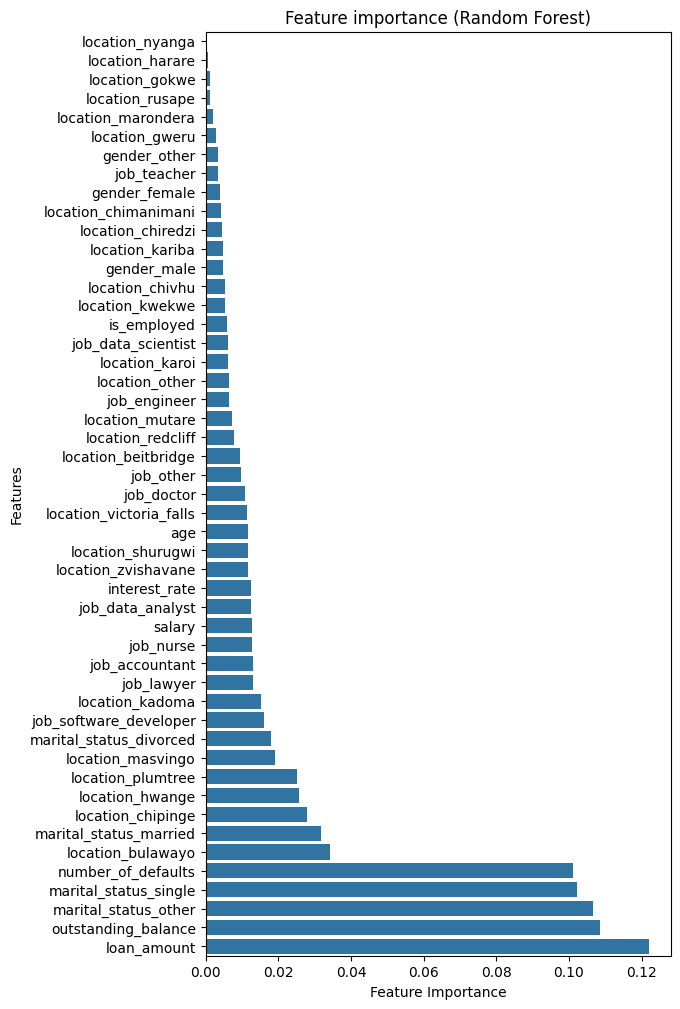

In [339]:
rf_fi = sorted(zip(rf.feature_importances_, X.columns))

fig, ax = plt.subplots(figsize=(6, 12))
ax = sns.barplot(
    x=[x[0] for x in rf_fi],
    y=[x[1] for x in rf_fi],
    ax=ax,
)
ax.set(xlabel="Feature Importance", ylabel="Features", title="Feature importance (Random Forest)")
plt.show()

In [340]:
y_pred = rf.predict(X_test)

In [341]:
display_classification_report(y_test, y_pred)

Accuracy: 0.9781904761904762


Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17831
           1       0.98      0.87      0.92      3169

    accuracy                           0.98     21000
   macro avg       0.98      0.93      0.96     21000
weighted avg       0.98      0.98      0.98     21000



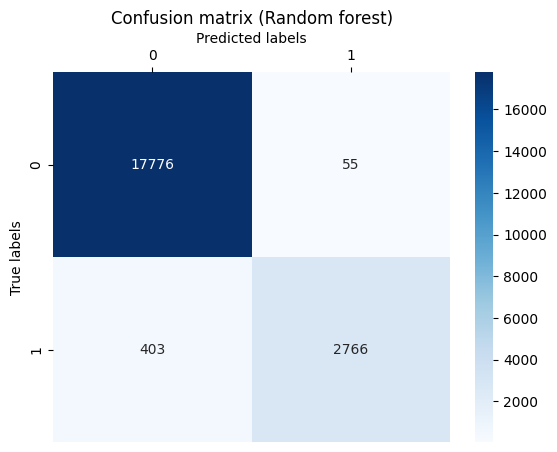

In [342]:
plot_confusion_matirx(y_test, y_pred, "Random forest")

## xgboost

In [343]:
from xgboost import XGBClassifier

In [344]:
params = {
    'n_estimators': [180, 200, 220],
    'max_depth': [6, 8, 12, 16],
    'scale_pos_weight': [1.6, 1.8, 2, 2.2]
}

In [345]:
xgb = XGBClassifier(eta=0.1)

In [346]:
xgb_search = GridSearchCV(xgb, params, n_jobs=-1, cv=4, verbose=2, scoring='f1_weighted')

In [347]:
xgb_search.fit(X_train, y_train)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] END max_depth=6, n_estimators=180, scale_pos_weight=1.6; total time=   5.3s
[CV] END max_depth=6, n_estimators=180, scale_pos_weight=1.8; total time=   5.4s
[CV] END max_depth=6, n_estimators=180, scale_pos_weight=1.6; total time=   5.8s
[CV] END max_depth=6, n_estimators=180, scale_pos_weight=1.8; total time=   6.1s
[CV] END max_depth=6, n_estimators=180, scale_pos_weight=1.8; total time=   6.2s
[CV] END max_depth=6, n_estimators=180, scale_pos_weight=1.6; total time=   7.3s
[CV] END max_depth=6, n_estimators=180, scale_pos_weight=1.6; total time=   7.4s


/home/t12e/miniconda3/envs/ai/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=6, n_estimators=180, scale_pos_weight=1.8; total time=   6.2s
[CV] END ..max_depth=6, n_estimators=180, scale_pos_weight=2; total time=   4.5s
[CV] END ..max_depth=6, n_estimators=180, scale_pos_weight=2; total time=   6.8s
[CV] END ..max_depth=6, n_estimators=180, scale_pos_weight=2; total time=   6.6s
[CV] END ..max_depth=6, n_estimators=180, scale_pos_weight=2; total time=   6.3s
[CV] END max_depth=6, n_estimators=180, scale_pos_weight=2.2; total time=   6.5s
[CV] END max_depth=6, n_estimators=180, scale_pos_weight=2.2; total time=   7.3s
[CV] END max_depth=6, n_estimators=180, scale_pos_weight=2.2; total time=   6.0s
[CV] END max_depth=6, n_estimators=200, scale_pos_weight=1.6; total time=   7.4s
[CV] END max_depth=6, n_estimators=180, scale_pos_weight=2.2; total time=   6.2s
[CV] END max_depth=6, n_estimators=200, scale_pos_weight=1.6; total time=   6.6s
[CV] END max_depth=6, n_estimators=200, scale_pos_weight=1.6; total time=   6.9s
[CV] END max_depth=6, n_esti

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eta=0.1,
                                     eval_metric=None, feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_ra...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 12, 16],
                         'n_estimators': [180, 200, 220],
                         'scale_pos_weight': [1.6, 1.8, 2, 2.2]},
             scoring='f1_weighted', verbose=2)

In [348]:
print(f"Best hyperparams: {xgb_search.best_params_}")
print(f"Best score: {xgb_search.best_score_}")

Best hyperparams: {'max_depth': 8, 'n_estimators': 220, 'scale_pos_weight': 1.6}
Best score: 0.9243607454834494


In [349]:
xgb = XGBClassifier(**xgb_search.best_params_)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=220, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

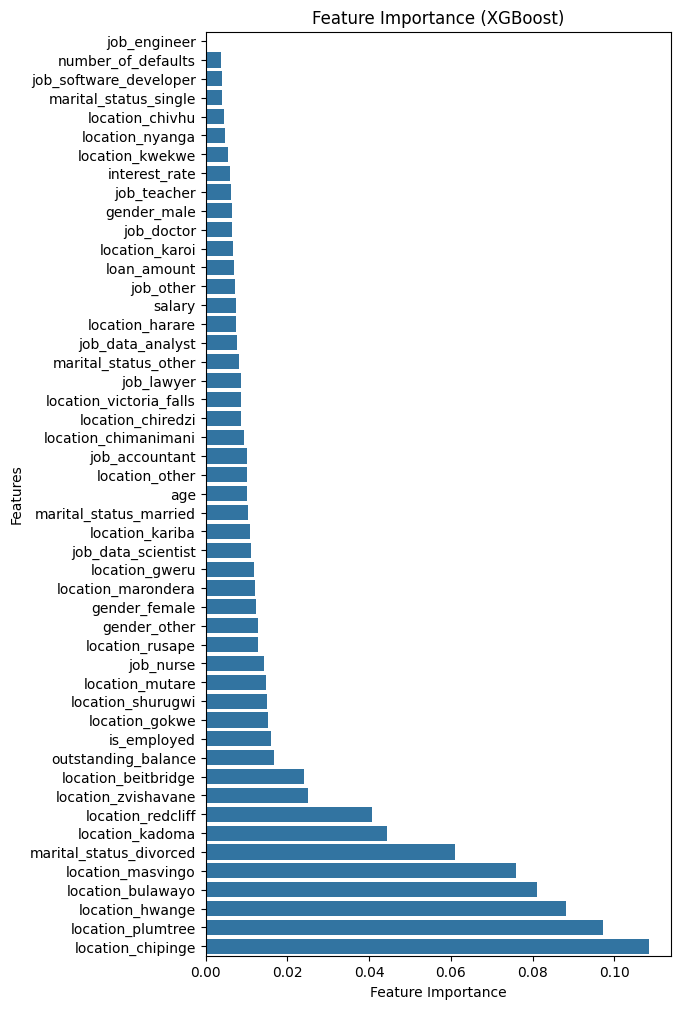

In [350]:
xgb_fi = sorted(zip(xgb.feature_importances_, X.columns))

fig, ax = plt.subplots(figsize=(6, 12))
ax = sns.barplot(
    x=[x[0] for x in xgb_fi],
    y=[x[1] for x in xgb_fi],
    ax=ax,
)
ax.set(xlabel="Feature Importance", ylabel="Features", title="Feature Importance (XGBoost)")
plt.show()

In [351]:
y_pred = xgb.predict(X_test)

In [352]:
display_classification_report(y_test, y_pred)

Accuracy: 0.9651904761904762


Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17831
           1       0.94      0.82      0.88      3169

    accuracy                           0.97     21000
   macro avg       0.96      0.91      0.93     21000
weighted avg       0.96      0.97      0.96     21000



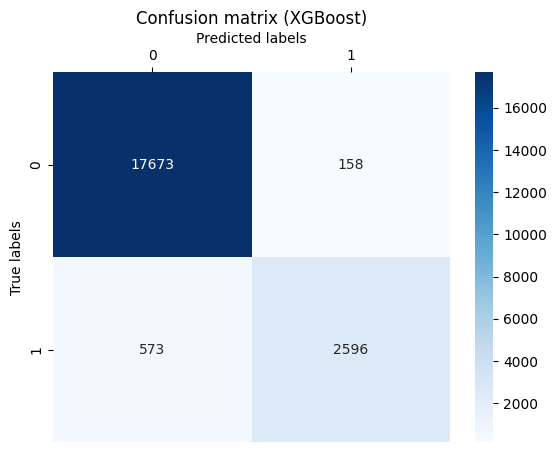

In [353]:
plot_confusion_matirx(y_test, y_pred, "XGBoost")

## Model evaluation

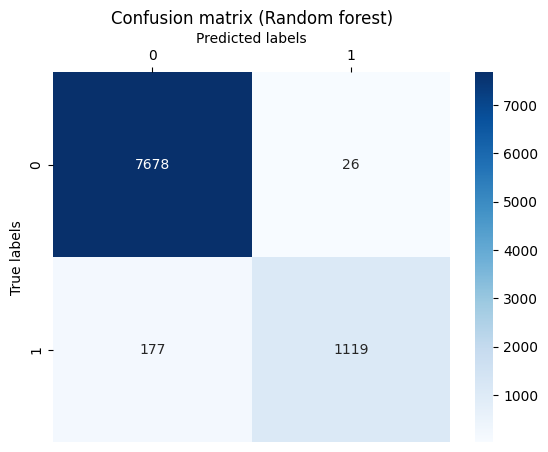

In [354]:
y_pred = rf.predict(X_val)
plot_confusion_matirx(y_val, y_pred, "Random forest")

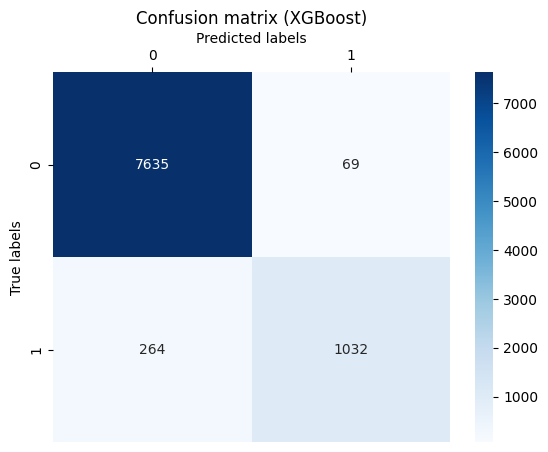

In [355]:
y_pred = xgb.predict(X_val)
plot_confusion_matirx(y_val, y_pred, "XGBoost")

## Save model

In [357]:
from datetime import datetime
import pickle

# save transformation pipeline


# save model
pickle.dump(rf, open("../artifacts/random-forest.sav", 'wb'))